## Importing Packages

In [1]:
pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchsummary import summary
import torchvision
from torchvision.models import squeezenet1_1, SqueezeNet1_1_Weights
from tqdm import tqdm
from sklearn.metrics import f1_score
import os
from torch.optim.lr_scheduler import StepLR
import random
import numpy as np
import matplotlib.pyplot as plt



In [21]:
if torch.backends.mps.is_available():
  torch.set_default_device('mps')

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

print("device: ", device)

device:  mps


In [22]:
# Set a random seed for reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)       # Python random module
    np.random.seed(seed_value)    # Numpy module
    torch.manual_seed(seed_value) # Torch
    os.environ['PYTHONHASHSEED'] = str(seed_value)  # Environment variable

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  # if using multi-GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(24)

## Importing the Dataset

In [8]:
'TODO: Define transformations - crop or resize'
transform = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for pre-trained models
])

"""

In order to load the datasets from the shared folder, go to google drive, right click the shared folder, and create a shortcut
to somewhere in your drive.

"""

# Ben's dataset paths
ben_train_dataset_path = "/content/gdrive/MyDrive/24S Classes/Deep Learning/COSC78 Final Project/Train Data"
ben_validation_dataset_path = "/content/gdrive/MyDrive/24S Classes/Deep Learning/COSC78 Final Project/Validation Data"
ben_test_dataset_path = "/content/gdrive/MyDrive/24S Classes/Deep Learning/COSC78 Final Project/Test Data"


# Dawson's dataset paths
daw_train_dataset_path = '/content/gdrive/MyDrive/COSC78 Final Project/Train Data'
daw_validation_dataset_path = '/content/gdrive/MyDrive/COSC78 Final Project/Validation Data'
daw_test_dataset_path = '/content/gdrive/MyDrive/COSC78 Final Project/Test Data'

# Will's dataset paths
will_train_dataset_path = '/content/gdrive/MyDrive/COSC78/COSC78 Final Project/Train Data'
will_validation_dataset_path = '/content/gdrive/MyDrive/COSC78/COSC78 Final Project/Validation Data'
will_test_dataset_path = '/content/gdrive/MyDrive/COSC78/COSC78 Final Project/Test Data'

# Brian's dataset paths
bri_train_dataset_path = '/content/gdrive/MyDrive/Algorithms - Collab/CS 78/COSC78 Final Project/Train Data'
bri_val_dataset_path = '/content/gdrive/MyDrive/Algorithms - Collab/CS 78/COSC78 Final Project/Validation Data'
bri_test_dataset_path = '/content/gdrive/MyDrive/Algorithms - Collab/CS 78/COSC78 Final Project/Test Data'

# Brian's laptop
bri1_train_dataset_path = '/Users/brianng/Downloads/Oasis/Test Data'
bri1_val_dataset_path = '/Users/brianng/Downloads/Oasis/Validation Data'
bri1_test_dataset_path = '/Users/brianng/Downloads/Oasis/Test Data'

#% Dataset paths in use %# (currently brian's)
train_dataset_path = bri1_train_dataset_path
validation_dataset_path = bri1_val_dataset_path
test_dataset_path = bri1_test_dataset_path


generator = torch.Generator(device=device)


with torch.device(device):
    # Setup datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_dataset_path, transform=transform)
    val_dataset = datasets.ImageFolder(validation_dataset_path, transform=transform)
    test_dataset = datasets.ImageFolder(test_dataset_path, transform=transform)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=generator)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, generator=generator)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, generator=generator)

## Import and modify the model

In [9]:
# Load the pre-trained SqueezeNet 1_1 model
pretrained_weights = squeezenet1_1(pretrained=True)
squeezenet = pretrained_weights

# Freeze all the parameters for fine-tuning
for param in squeezenet.parameters():
    param.requires_grad = False

# Replace the classifier head
num_classes = 3  # Number of classes in your dataset
squeezenet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
squeezenet.classifier[1].requires_grad_ = True

# Optionally add more non-linear layers
squeezenet.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Conv2d(512, 256, kernel_size=(1,1), stride=(1,1)),
    nn.ReLU(),
    nn.Conv2d(256, num_classes, kernel_size=(1,1), stride=(1,1)),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Softmax(dim=1)
)


# Print the model summary
summary(squeezenet, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 111, 111]           1,792
              ReLU-2         [-1, 64, 111, 111]               0
         MaxPool2d-3           [-1, 64, 55, 55]               0
            Conv2d-4           [-1, 16, 55, 55]           1,040
              ReLU-5           [-1, 16, 55, 55]               0
            Conv2d-6           [-1, 64, 55, 55]           1,088
              ReLU-7           [-1, 64, 55, 55]               0
            Conv2d-8           [-1, 64, 55, 55]           9,280
              ReLU-9           [-1, 64, 55, 55]               0
             Fire-10          [-1, 128, 55, 55]               0
           Conv2d-11           [-1, 16, 55, 55]           2,064
             ReLU-12           [-1, 16, 55, 55]               0
           Conv2d-13           [-1, 64, 55, 55]           1,088
             ReLU-14           [-1, 64,

/Users/brianng/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/brianng/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Fine tune the model

In [10]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(squeezenet.parameters())

In [11]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(squeezenet.parameters(),lr=1e-3)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Decreases the learning rate by a factor of 0.1 every 10 epochs
torch.manual_seed(24)

In [12]:
def train_and_validate(model, train_loader, val_loader, optimizer, scheduler, loss_func, epochs=25, patience=5, save_path='best_model.pth'):
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # To store the training and validation loss for plotting or analysis
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': [], 'train_f1': [], 'val_f1': []}

    best_val_loss = float('inf')
    patience_counter = 0  # Counter for the early stopping

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        train_preds, train_targets = [], []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

            train_preds.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_accuracy = 100 * correct_train / total_train
        train_f1 = f1_score(train_targets, train_preds, average='weighted')
        epoch_train_loss = train_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['train_f1'].append(train_f1)

        # Scheduler step (commonly after training step, can be adjusted as per scheduler type)
        scheduler.step()

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        val_preds, val_targets = [], []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_func(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

                val_preds.extend(predicted.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_accuracy = 100 * correct_val / total_val
        val_f1 = f1_score(val_targets, val_preds, average='weighted')
        epoch_val_loss = val_loss / len(val_loader.dataset)
        history['val_loss'].append(epoch_val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_f1'].append(val_f1)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train F1: {train_f1:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation F1: {val_f1:.4f}')

        # Check for improvement in validation loss
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), save_path)  # Save the best model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Stopping early after {epoch + 1} epochs due to no improvement in validation loss.")
                model.load_state_dict(torch.load(save_path))  # Load the best model weights
                break

    return history

Tried adding non-linear layers - validation accuracy got worse
Decreased batch size to 32 - starting point was worse but improved

In [13]:
history = train_and_validate(squeezenet, train_loader, val_loader, optimizer, scheduler, loss_func, epochs=5)

Epoch 1/5 - Validation: 100%|██████████| 164/164 [01:12<00:00,  2.25it/s]


Epoch [1/5], Train Loss: 0.7908, Train Accuracy: 75.91%, Train F1: 0.6598, Validation Loss: 0.7613, Validation Accuracy: 79.02%, Validation F1: 0.6975


Epoch 2/5 - Validation: 100%|██████████| 164/164 [01:11<00:00,  2.28it/s]


Epoch [2/5], Train Loss: 0.7884, Train Accuracy: 76.31%, Train F1: 0.6605, Validation Loss: 0.7613, Validation Accuracy: 79.02%, Validation F1: 0.6975


Epoch 3/5 - Validation: 100%|██████████| 164/164 [01:12<00:00,  2.26it/s]


Epoch [3/5], Train Loss: 0.7884, Train Accuracy: 76.31%, Train F1: 0.6605, Validation Loss: 0.7613, Validation Accuracy: 79.02%, Validation F1: 0.6975


Epoch 4/5 - Validation: 100%|██████████| 164/164 [01:12<00:00,  2.25it/s]


Epoch [4/5], Train Loss: 0.7884, Train Accuracy: 76.31%, Train F1: 0.6605, Validation Loss: 0.7613, Validation Accuracy: 79.02%, Validation F1: 0.6975


Epoch 5/5 - Validation: 100%|██████████| 164/164 [01:13<00:00,  2.23it/s]

Epoch [5/5], Train Loss: 0.7884, Train Accuracy: 76.31%, Train F1: 0.6605, Validation Loss: 0.7613, Validation Accuracy: 79.02%, Validation F1: 0.6975


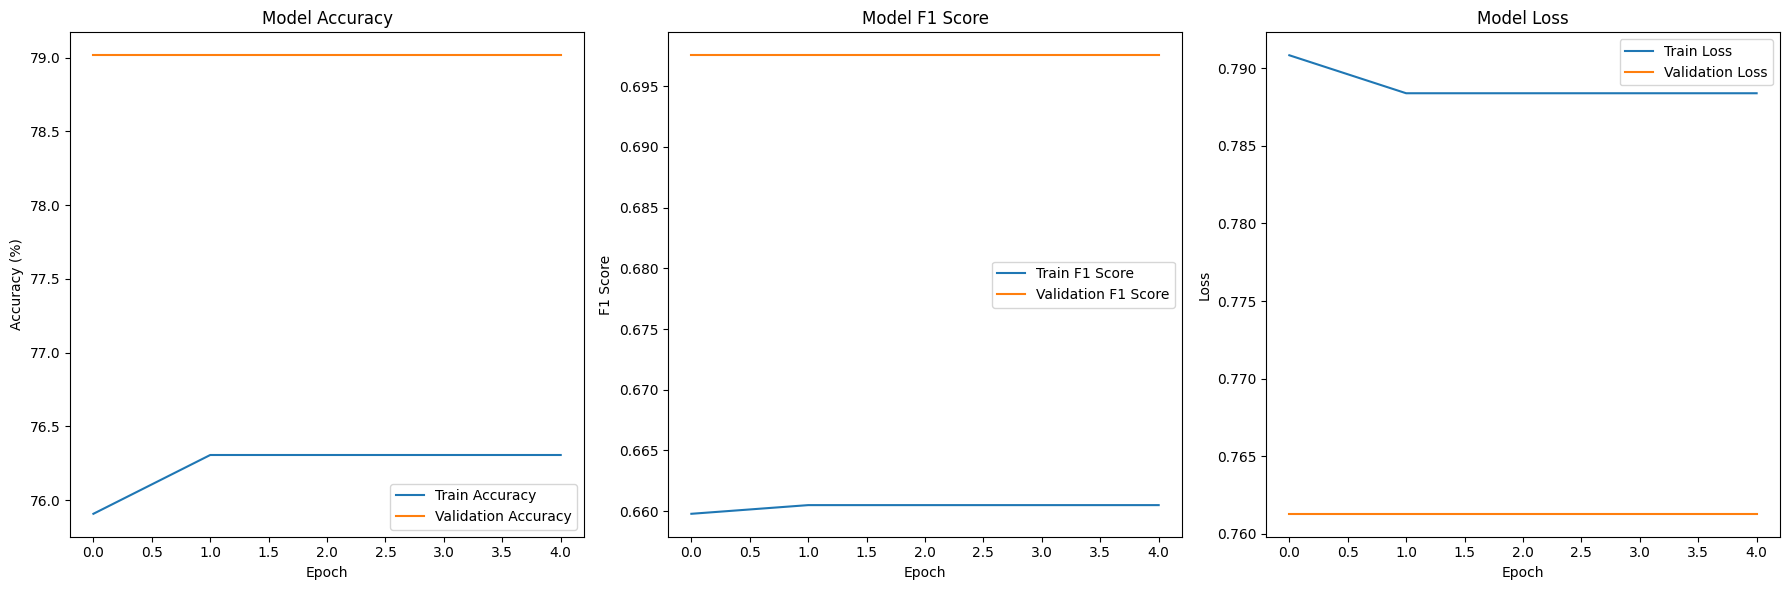

In [16]:
# Plotting training and validation accuracy
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(history['train_accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plotting training and validation F1 score
plt.subplot(1, 3, 2)
plt.plot(history['train_f1'], label='Train F1 Score')
plt.plot(history['val_f1'], label='Validation F1 Score')
plt.title('Model F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 3, 3)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
def evaluate_model(model, dataloader, device='cuda', save_path='model_final.pth'):
    model.eval()  # Set model to evaluation mode
    true_labels = []
    predictions = []
    
    # No gradient needed
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate performance metrics
    precision = precision_score(true_labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(true_labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='weighted', zero_division=0)

    # Save model weights
    torch.save(model.state_dict(), save_path)

    # Save performance metrics to a file
    with open('test_performance.txt', 'w') as f:
        f.write(str(hyperparameters) + '\n')
        f.write(f'Precision: {precision:.4f}\n')
        f.write(f'Recall: {recall:.4f}\n')
        f.write(f'F1 Score: {f1:.4f}\n')

    # Output metrics
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    plot_confusion_matrix(cm, classes=['Mild Dementia', 'Very Mild Dementia', 'Non Demented'])

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be added by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in enumerate(np.meshgrid(np.arange(cm.shape[0]), np.arange(cm.shape[1]))[0]):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [23]:
evaluate_model(squeezenet, test_loader)